In [6]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from scipy.sparse import csr_matrix
import torch
from sklearn import metrics
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import argparse
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def load_ctcf(ctcf_path, chrom, start=None):
    ctcf_all = pickle.load(open(ctcf_path, 'rb'))
    ctcf = ctcf_all['chr{}'.format(chrom)].toarray()[0]
    if start is not None:
        ctcf = ctcf[start*200: (start+700)*200]

    return ctcf


def load_atac(atac_path, chrom, start=None):
    atac_all = pickle.load(open(atac_path, 'rb'))
    atac = atac_all['chr{}'.format(chrom)].flatten()
    if start is not None:
        atac = atac[start*200: (start+700)*200]

    return atac


def process_scatac(scatac_pre, metacell, start):
    tmp = torch.tensor((metacell * scatac_pre)[:, start*20:(start+700)*20].toarray()).T

    size, eps = tmp.shape[1], 1e-8
    one, zero = torch.tensor(1.0), torch.tensor(0.0)
    lrg = torch.where(tmp>0, one, zero)
    eql = torch.where(tmp==0, one, zero)
    num, denom = lrg @ lrg.T, size - eql @ eql.T
    scatac = torch.div(num, torch.max(denom, eps * torch.ones_like(denom)))
    scatac[scatac != scatac] = 0

    scatac = scatac.reshape(
        scatac.shape[0]//20, 20, -1
    ).mean(axis=1).reshape(
        -1, scatac.shape[1]//20, 20
    ).mean(axis=2)

    return scatac


def load_scatac(scatac_path, metacell_path, chrom, start=None):
    scatac_pre = pickle.load(open(scatac_path, 'rb'))['chr{}'.format(chrom)]
    metacell = csr_matrix(pd.read_csv(metacell_path, index_col=0).values)

    if start is not None:
        scatac = process_scatac(scatac_pre, metacell, start)
        return scatac, metacell
    else:
        return scatac_pre, metacell


def load_multiome(input_dir, ct, chrom, start=None, genome='mm10'):
    ctcf_path = osp.join(input_dir, 'dna', '{}_ctcf_motif_score.p'.format(genome))
    atac_path = osp.join(input_dir, 'atac', '{}_tile_pbulk_50bp_dict.p'.format(ct))
    scatac_path = osp.join(input_dir, 'atac', '{}_tile_500bp_dict.p'.format(ct))
    metacell_path = osp.join(input_dir, 'atac', '{}_metacell_mask.csv'.format(ct))

    ctcf = load_ctcf(ctcf_path, chrom, start=start)
    atac = load_atac(atac_path, chrom, start=start)
    scatac, metacell = load_scatac(scatac_path, metacell_path, chrom, start=start)

    return ctcf, atac, scatac, metacell


def load_pred(pred_dir, ct, chrom, pred_len=200, avg_stripe=False):
    file = osp.join(pred_dir, ct, 'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    chrom_len = temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array([
        np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)
    ])
    summed = np.vstack((
        np.zeros((pred_len, mat.shape[1])), mat
    )).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack((
            np.zeros((pred_len, mat.shape[1])), mat
        ))[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    return summed[pred_len:-pred_len, pred_len:-pred_len]

In [5]:
def topdom(pred_mat, window_size=10, cutoff=0):
    if pred_mat.shape[0]-pred_mat.shape[1]:
        raise ValueError(
            'Dimension mismatch ({}, {})'.format(pred_mat.shape[0], pred_mat.shape[1])
        )
    pad_mat = np.pad(pred_mat, window_size, mode='constant', constant_values=np.nan)
    dim = pad_mat.shape[0]
    signal = np.array([
        np.nanmean(pad_mat[i-window_size:i, i:i+window_size]) for i in range(dim)
    ][window_size+1: -window_size])
    if cutoff is not None:
        signal[signal<cutoff] = cutoff

    return signal


def interpolate(signal, bin_size=10000, pattern='smooth'):
    if pattern is None: return signal
    if pattern not in ['smooth', 'zigzag']:
        raise ValueError(
            'Bad parameter, expecting \'smooth\' or \'zigzag\' but got \'{}\''.format(pattern)
        )
    if pattern=='smooth':
        l = len(signal) * bin_size
        sparse, compact = np.linspace(0, l, len(signal)), np.linspace(0, l, l)
        interp_signal = np.interp(compact, sparse, signal)
    else:
        interp_signal = np.tile(signal, (bin_size, 1)).flatten('F')
    
    return interp_signal


def sim_pearson(signal1, signal2, window_size=10):
    l = len(signal1)
    score = np.array([
        scipy.stats.pearsonr(
            signal1[i:i+window_size], signal2[i:i+window_size]
        )[0] for i in range(l-window_size)
    ])
    score[score != score] = 1

    return score


def sim_difference(signal1, signal2):
    score = signal1 - signal2
    score[score != score] = 0

    return score


def similarity(signal1, signal2, kernel='diff', window_size=10):
    if len(signal1)-len(signal2):
        raise ValueError(
            'Different signal1.length ({}) and signal2.length ({})'.format(len(signal1), len(signal2))
        )
    if kernel == 'diff':
        score = sim_difference(signal1, signal2)
    elif kernel == 'pearson':
        score = sim_pearson(signal1, signal2, window_size=window_size)
    
    return score

In [56]:
input_dir = '/data/leslie/suny4/processed_input/'
pred_dir = '/data/leslie/suny4/predictions/chromafold/'
chrom = 1

In [68]:
def check_distr(ct1, ct2):
    ctcf, atac1, scatac1, metacell1 = load_multiome(input_dir, ct1, chrom, start=None)
    _, atac2, scatac2, metacell2 = load_multiome(input_dir, ct2, chrom, start=None)

    print(np.max(atac1), np.mean(atac1), np.std(atac1), sep='\t')
    print(np.max(atac2), np.mean(atac2), np.std(atac2), sep='\t')

    plt.figure(figsize=(8,5))
    plt.plot(atac1, alpha=0.5, label=ct1)
    plt.plot(atac2, alpha=0.5, label=ct2)
    plt.legend()
    plt.show()

In [69]:
def check_topdom(ct1, ct2):
    pred1 = load_pred(pred_dir, ct1, chrom, avg_stripe=True)
    pred2 = load_pred(pred_dir, ct2, chrom, avg_stripe=True)
    signal1, signal2 = topdom(pred1, cutoff=None), topdom(pred2, cutoff=None)
    
    print(np.min(signal1), np.max(signal1), np.mean(signal1), np.std(signal1), sep='\t')
    print(np.min(signal2), np.max(signal2), np.mean(signal2), np.std(signal2), sep='\t')
    
    plt.figure(figsize=(8,5))
    plt.plot(signal1, label=ct1)
    plt.plot(signal2, label=ct2)
    plt.legend()
    plt.show()

872.0	1.0646225546369812	9.48477808699284
610.0	0.4627179340263567	4.3258872073884405


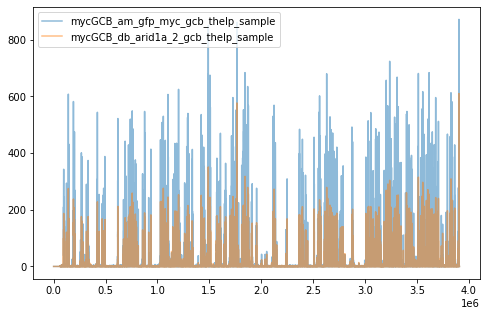

CPU times: user 20.1 s, sys: 1.17 s, total: 21.2 s
Wall time: 21.3 s


In [70]:
%%time

check_distr('mycGCB_am_gfp_myc_gcb_thelp_sample', 'mycGCB_db_arid1a_2_gcb_thelp_sample')

-1.0579694549242655	2.5057162088900804	-0.5006385773357679	0.5123764561738223
-1.0903890657424926	2.2888410070538523	-0.5111729892509804	0.47610452179838847


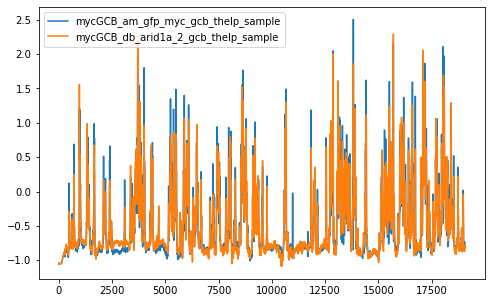

CPU times: user 12.7 s, sys: 8.5 s, total: 21.2 s
Wall time: 21.2 s


In [71]:
%%time

check_topdom('mycGCB_am_gfp_myc_gcb_thelp_sample', 'mycGCB_db_arid1a_2_gcb_thelp_sample')

872.0	1.0646225546369812	9.48477808699284
593.0	0.5014436850290579	5.73374406924201


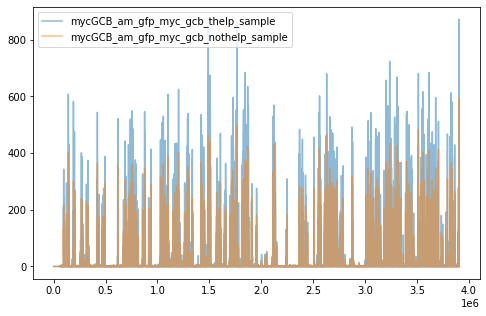

CPU times: user 20.1 s, sys: 1.15 s, total: 21.2 s
Wall time: 21.4 s


In [72]:
%%time

check_distr('mycGCB_am_gfp_myc_gcb_thelp_sample', 'mycGCB_am_gfp_myc_gcb_nothelp_sample')

-1.0579694549242655	2.5057162088900804	-0.5006385773357679	0.5123764561738223
-1.0579694549242655	2.2562272326648234	-0.49258064111783945	0.42241078528255077


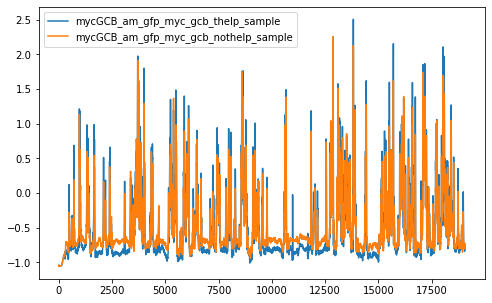

CPU times: user 12.5 s, sys: 8.57 s, total: 21.1 s
Wall time: 21.1 s


In [73]:
%%time

check_topdom('mycGCB_am_gfp_myc_gcb_thelp_sample', 'mycGCB_am_gfp_myc_gcb_nothelp_sample')

3213.0	3.8929795571744292	34.30398049812153
872.0	1.0646225546369812	9.48477808699284


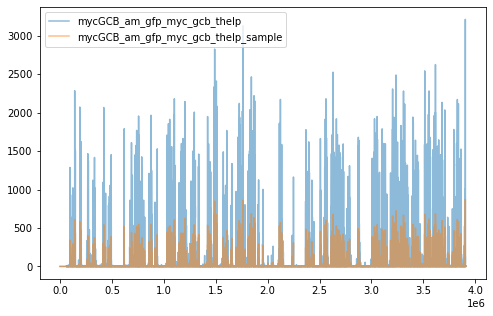

CPU times: user 21 s, sys: 815 ms, total: 21.8 s
Wall time: 21.8 s


In [74]:
%%time

check_distr('mycGCB_am_gfp_myc_gcb_thelp', 'mycGCB_am_gfp_myc_gcb_thelp_sample')

-1.0579694588979085	2.2481285847723482	-0.4886077817794075	0.5128791442041423
-1.0579694549242655	2.5057162088900804	-0.5006385773357679	0.5123764561738223


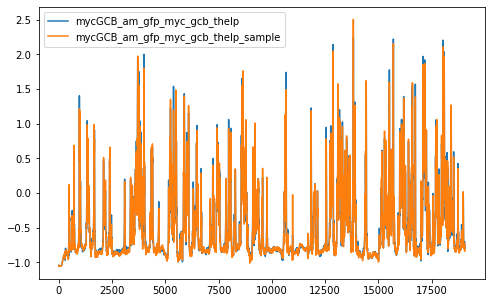

CPU times: user 12.7 s, sys: 6.32 s, total: 19 s
Wall time: 19.1 s


In [75]:
%%time

check_topdom('mycGCB_am_gfp_myc_gcb_thelp', 'mycGCB_am_gfp_myc_gcb_thelp_sample')